# Airbus Ship Detection

## Memebers
* Blaine Rothrock (BRY4768)
* Ilan Ponsky (IPW1530)
* Will Dong (WDG4518)

## Overview

Based on the kaggle challenge [Airbus Ship Detection Challenge](https://www.kaggle.com/c/airbus-ship-detection/overview). This challenge uses satellite images to detect if a image has ships and draw a box (mask) around the ship. This challenge contains ~40GB of data and the training size is a little out of scope for this project, so we approaching it with two goals:
1. Trainin a binary classifier to classify images that contain ship(s)
2. Explore the state-of-the-art approach to this model, U-Net
    - Goal is to follow the baseline notebook submission and understand the architechure. 

## 1. Binary Classifier

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, Input
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, UpSampling2D, GaussianNoise, BatchNormalization, concatenate, Cropping2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from skimage.io import imread
from sklearn.model_selection import train_test_split

from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import gc

gc.enable()

ship_dir = '../data/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

print(tf.__version__)

2.1.0


In [2]:
# define params for the model
class Params():
    def __init__(self):
        self.batch_size = 128
        self.epochs = 25
        self.image_size = (256, 256)
        
params = Params()

In [3]:
# read the mask data provided by kaggle
seg = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))
print(seg.shape[0], 'masks found')
print(seg['ImageId'].value_counts().shape[0], 'unique images found')
seg.sample()

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
156984,ad4cbaf50.jpg,127973 3 128737 7 129502 10 130270 10 131039 1...


In [4]:
# identify images that have a mask (ship identification)
from util import agg_ship_count
train_df = agg_ship_count(pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv')))
train_df.sample(10)

,ImageId,ship_count,has_ship,class
50139,42c6165b5.jpg,0,0,no_ship
146846,c33b6f61a.jpg,0,0,no_ship
114186,97ce4b3df.jpg,0,0,no_ship
168621,e0486b154.jpg,0,0,no_ship
187771,f9bce9370.jpg,0,0,no_ship
131053,ae36ae069.jpg,0,0,no_ship
99598,847c32266.jpg,3,1,ship
113387,96c7e17cf.jpg,0,0,no_ship
7119,097d83ec2.jpg,0,0,no_ship
102586,886df2530.jpg,0,0,no_ship


In [5]:
# Create a validation set by splitting the training data
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.3,
    stratify = train_df['has_ship']
)

print(train_df.shape[0], 'training samples')
print(valid_df.shape[0], 'validation samples')

133902 training samples
57387 validation samples


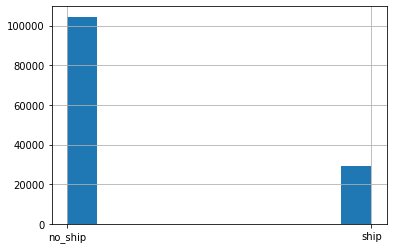

In [6]:
train_df['class'].hist()

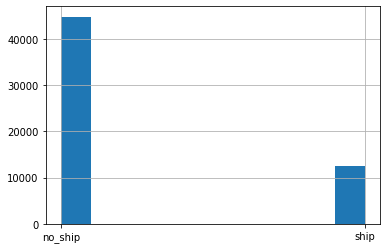

In [7]:
valid_df['class'].hist()

In [8]:
# normalize the image data (255 -> 1.0, 0 -> 0.0)
train_image_generator = ImageDataGenerator(rescale=1./255)
valid_image_generator = ImageDataGenerator(rescale=1./255)

In [103]:
# Training Image Generator
train_data_gen = train_image_generator.flow_from_dataframe(
    train_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=params.image_size,
    class_mode='binary',
    shuffle=True
)

KeyError: 'class'

In [104]:
# Validation Image Generator
valid_data_gen = valid_image_generator.flow_from_dataframe(
    valid_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=params.image_size,
    class_mode='binary',
    shuffle=True
)

KeyError: 'class'

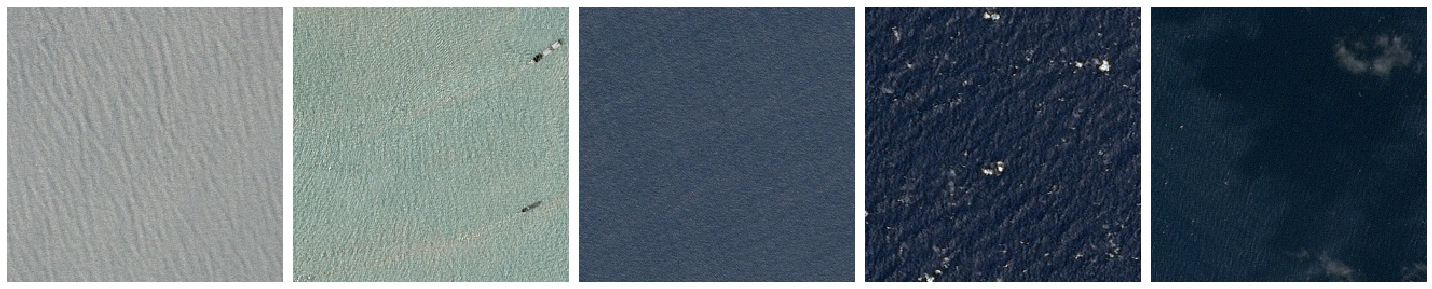

In [105]:
sample_training_images, _ = next(train_data_gen)
from util import plotImages
    
plotImages(sample_training_images[:10])

In [12]:
# model 4-layer CNN (see below for details)
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(256, 256 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [13]:
# ADAM optimizer
# Cross Entropy for loss
# Record accurarcy

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       7

In [15]:
# Save a model checkpoint at each epoch based on validation loss
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints', monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch'
)

# Stop early of overfitting (validation loss does not improve for 2+ epochs)
overfit = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3
)

In [16]:
# Train the model and record history
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_df.shape[0] // params.batch_size,
    epochs=100,
    callbacks=[checkpoint, overfit],
    validation_data=valid_data_gen,
    validation_steps=valid_df.shape[0] // params.batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1046 steps, validate for 448 steps
Epoch 1/100
1045/1046 [============================>.] - ETA: 0s - loss: 0.4703 - accuracy: 0.7832WARNING:tensorflow:From /home/b/.conda/envs/airbus/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: checkpoints/assets
1046/1046 [==============================] - 334s 319ms/step - loss: 0.4701 - accuracy: 0.7832 - val_loss: 0.3985 - val_accuracy: 0.8150
Epoch 2/100
 462/1046 [============>.................] - ETA: 2:08 - loss: 0.3427 - accuracy: 0.8500

KeyboardInterrupt: 

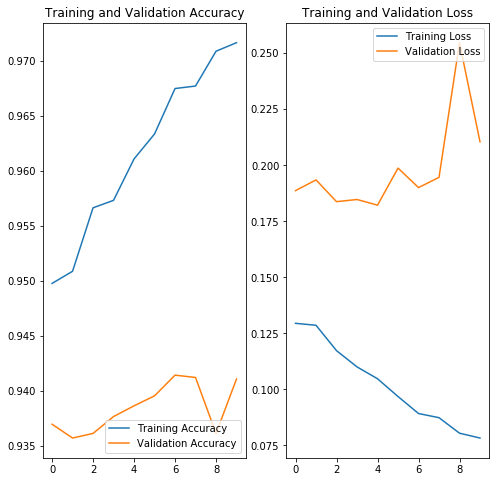

<Figure size 432x288 with 0 Axes>

In [24]:
# Plot history of loss and accurarcy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('binary_classifier_results2.png')

In [33]:
# garbage collect & clear Keras session before U-Net
gc.collect()
K.clear_session()

# 2. U-Net Model
Following [this](https://www.kaggle.com/kmader/baseline-u-net-model-part-1) submission notebook from Kaggle.

Mostly using code from the above notebook, but we rewrote the model in tensorflow2 in order to understand the architechure and simplified some components

In [8]:
class UNetParams():
    def __init__(self):
        self.batch_size = 4
        self.edge_crop = 16
        self.num_epochs= 100
        self.gaussian_noise = 0.1
        self.img_scaling = (1, 1)
        self.max_train_steps = 1000
        
unet_params = UNetParams()

In [10]:
# Get the masks from kaggle file
masks = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique images found')
masks.head(5)

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Check Decoding->Encoding RLE_0: 15 -> RLE_1: 5


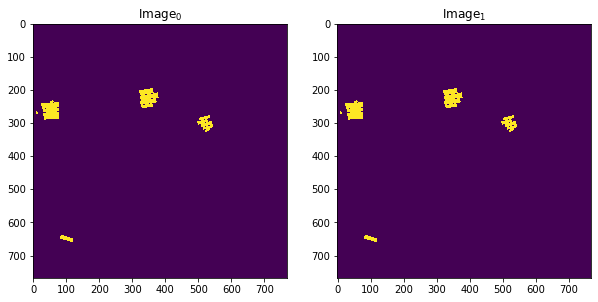

In [11]:
# Plot a mask to test the helper methods
# Image is hard coded to a image with max number of ships (15)
from util import masks_as_image
from util import multi_rle_encode
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="11f3bae66.jpg"')['EncodedPixels'] # 15 ships in the image
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
142490,bd727b492.jpg,0,0.0,[0.0],106.911133
25197,219d9469a.jpg,0,0.0,[0.0],91.749023
1250,019f47360.jpg,0,0.0,[0.0],216.545898
144885,c0a7f8498.jpg,0,0.0,[0.0],80.283203
141511,bc136070e.jpg,0,0.0,[0.0],172.251953


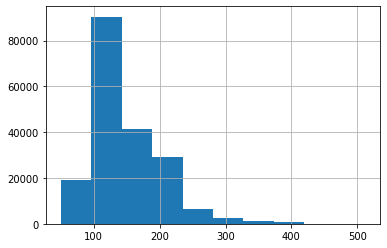

In [12]:
# group images by number of ships
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

# Remove images with < 50kb, the could be corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024 if os.path.exists(os.path.join(train_image_dir, c_img_id)) else 0.0)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [13]:
# Split training into training and validation sets

from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

161048 training masks
69034 validation masks


In [15]:
from util import make_image_gen
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 0.8823529411764706
y (4, 768, 768, 1) 0 0


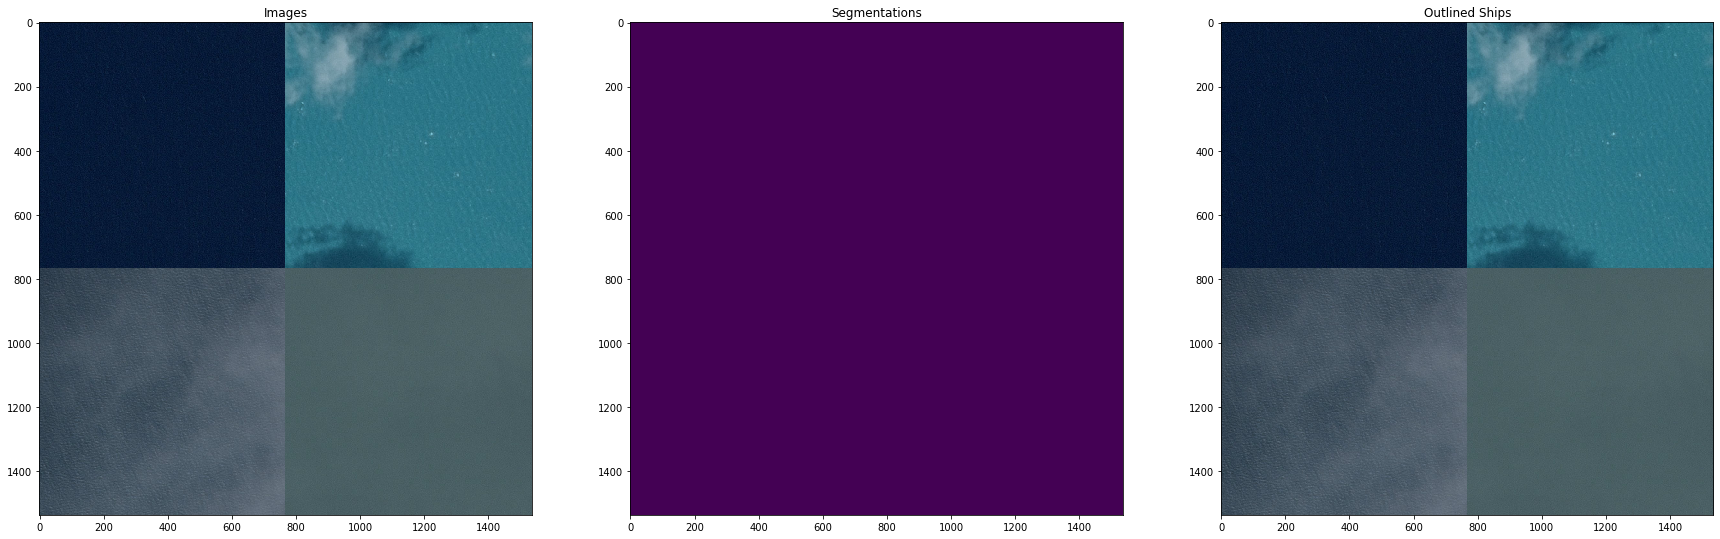

In [20]:
# plot the batching with masks
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('images/overview.png')

In [21]:
valid_x, valid_y = next(make_image_gen(valid_df))
print(valid_x.shape, valid_y.shape)

(4, 768, 768, 3) (4, 768, 768, 1)


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dg_args = dict(
    featurewise_center = False, 
    samplewise_center = False,
    rotation_range = 15, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    shear_range = 0.01,
    zoom_range = [0.9, 1.25],  
    horizontal_flip = True, 
    vertical_flip = True,
    fill_mode = 'reflect',
    data_format = 'channels_last'
)

# brightness can be problematic since it seems to change the labels differently from the images 

image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


Text(0.5, 1.0, 'ships')

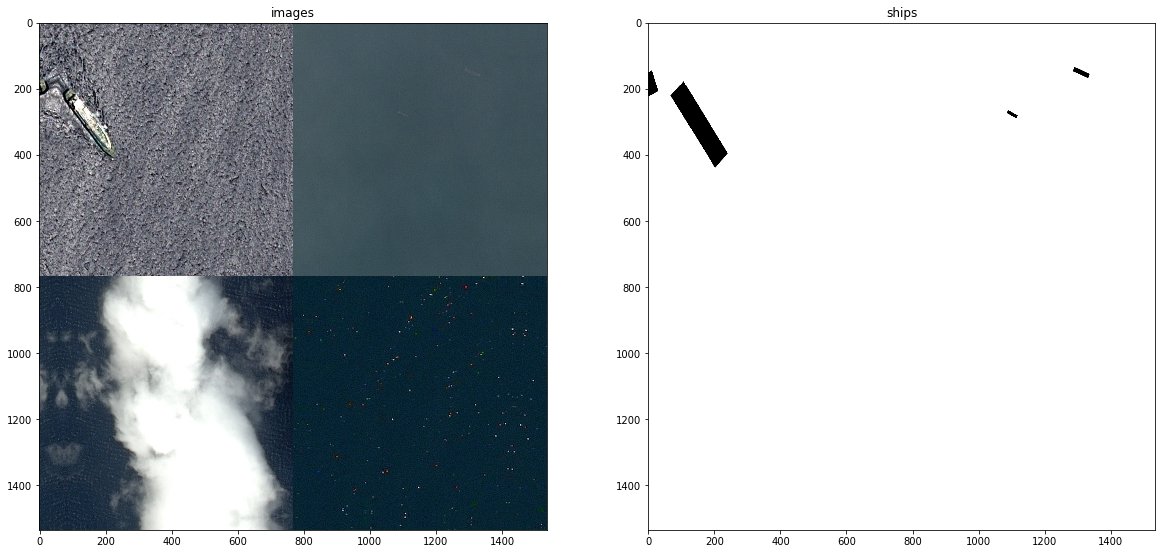

In [26]:
from util import create_aug_gen
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [27]:
# garbarge collect before building the model
gc.collect()
K.clear_session()

In [28]:
# Build the U-Net Model

input_img = Input(t_x.shape[1:], name = 'RGB_Input')
input_layer = GaussianNoise(unet_params.gaussian_noise)(input_img)
input_layer = BatchNormalization()(input_layer)

from util import conv_down
from util import conv_up
from util import pool

d1 = conv_down(8, input_img, name='d1')
dp1 = pool(d1, name='d1')
d2 = conv_down(16, dp1, name='d2')
dp2 = pool(d2, name='d2')
d3 = conv_down(32, dp2, name='d3')
dp3 = pool(d3, name='d3')
d4 = conv_down(64, dp3, name='d4')
dp4 = pool(d4, name='d4')
b = conv_down(128, dp4, name='b')
u1 = conv_up(64, b, d4, name='u1')
u2 = conv_up(32, u1, d3, name='u2')
u3 = conv_up(16, u2, d2, name='u3')
u4 = conv_up(8, u3, d1, name='u4')

out = Conv2D(1, (1, 1), activation='sigmoid', name='out_conv1')(u4)
out = Cropping2D((unet_params.edge_crop, unet_params.edge_crop), name='out_crop')(out)
out = ZeroPadding2D((unet_params.edge_crop, unet_params.edge_crop), name='out_pad')(out)

unet = models.Model(inputs=[input_img], outputs=[out], name="UNet")
unet.summary()

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
d1_conv1 (Conv2D)               (None, 768, 768, 8)  224         RGB_Input[0][0]                  
__________________________________________________________________________________________________
d1_conv2 (Conv2D)               (None, 768, 768, 8)  584         d1_conv1[0][0]                   
__________________________________________________________________________________________________
d1_pool (MaxPooling2D)          (None, 384, 384, 8)  0           d1_conv2[0][0]                   
_______________________________________________________________________________________________

In [29]:
# Loss and metrics
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from util import dice_coef

unet.compile(optimizer=Adam(1e-4), loss=binary_crossentropy, metrics=[dice_coef])

In [30]:
# model callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(
    weight_path, 
    monitor='val_dice_coef', 
    verbose=1, 
    save_best_only=True, 
    mode='max', 
    save_weights_only = True
)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_dice_coef', 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    mode='max', 
    epsilon=0.0001, 
    cooldown=2, 
    min_lr=1e-6
)

early = EarlyStopping(
    monitor="val_dice_coef", 
    mode="max", 
    patience=15
)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
step_count = min(unet_params.max_train_steps, train_df.shape[0]//unet_params.batch_size)
aug_gen = create_aug_gen(make_image_gen(train_df))

loss_history = [
    unet.fit(
        aug_gen, 
        steps_per_epoch=step_count, 
        epochs=unet_params.num_epochs, 
        validation_data=(valid_x, valid_y),
        callbacks=callbacks_list
    )
]

  ...
    to  
  ['...']
Train for 1000 steps, validate on 4 samples
Epoch 1/100
 151/1000 [===>..........................] - ETA: 6:27 - loss: 0.1721 - dice_coef: 0.5384

In [ ]:
from util import show_loss

show_loss(loss_history)

In [ ]:
# save model
seg_model.load_weights(weight_path)
seg_model.save('seg_model_03_05_midnight.h5')

if params.img_scaling is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(params.img_scaling, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(params.img_scaling))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model_03_05_midnight.h5')

. ../data/test_v2/.


ValueError: Could not find a format to read the specified file in mode 'i'

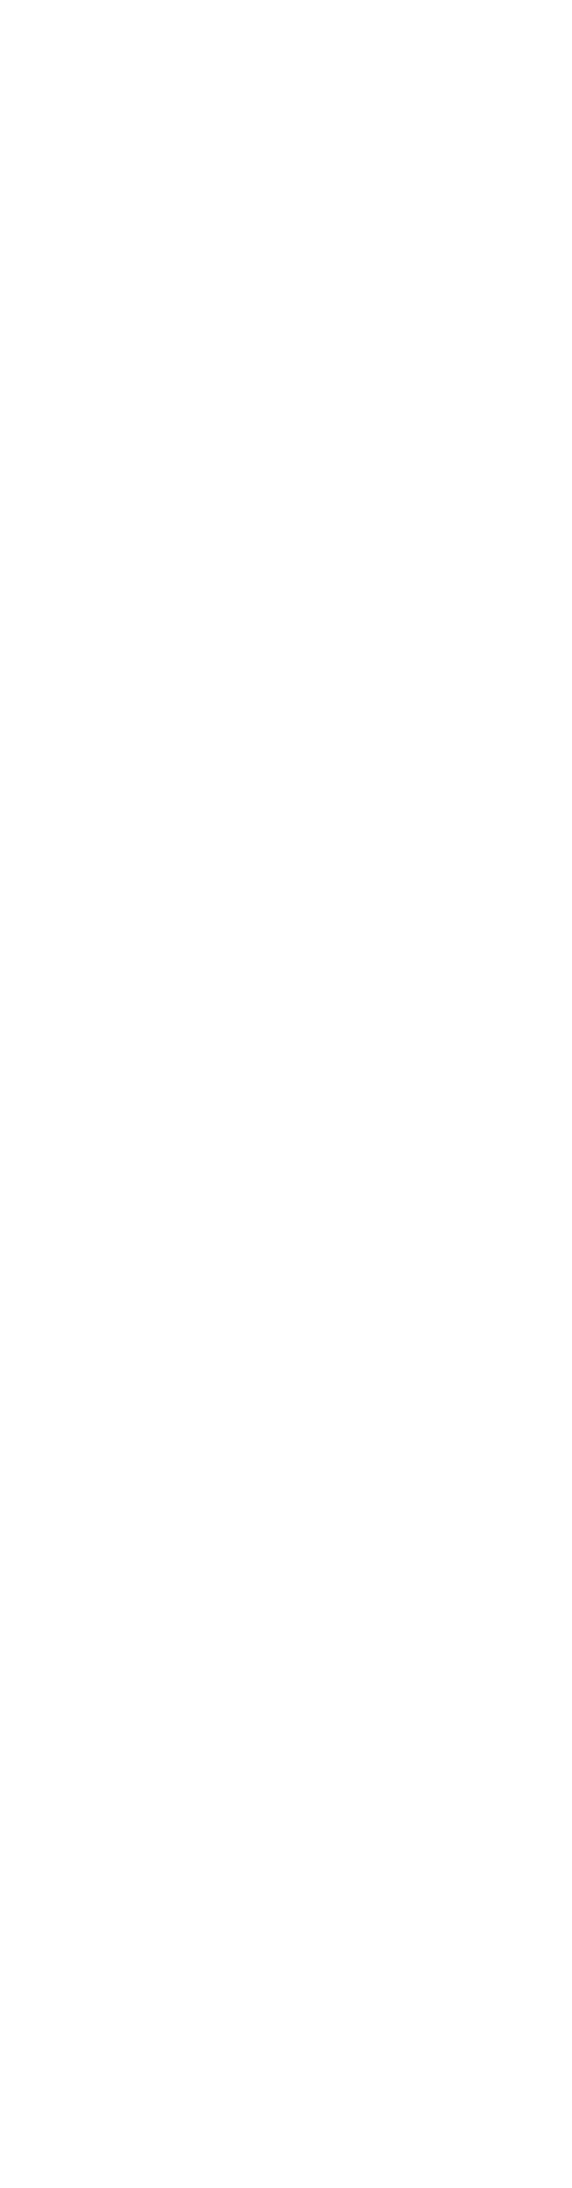

In [93]:
# Predict
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_image_dir):
    c_path = os.path.join(test_image_dir, c_img_name)
    print(c_img_name, c_path)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions_03_05_midnight_02.png')